In [163]:
import arviz as az
import pandas as pd
import pymc as pm
from matplotlib import rcParams, pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

In [164]:
df = pd.read_csv('data/h1weekly.csv',
                 parse_dates=['Date'],
                 index_col='Date',
                 dtype={'IsCanceled': float})
df.index.freq = 'W-SUN'

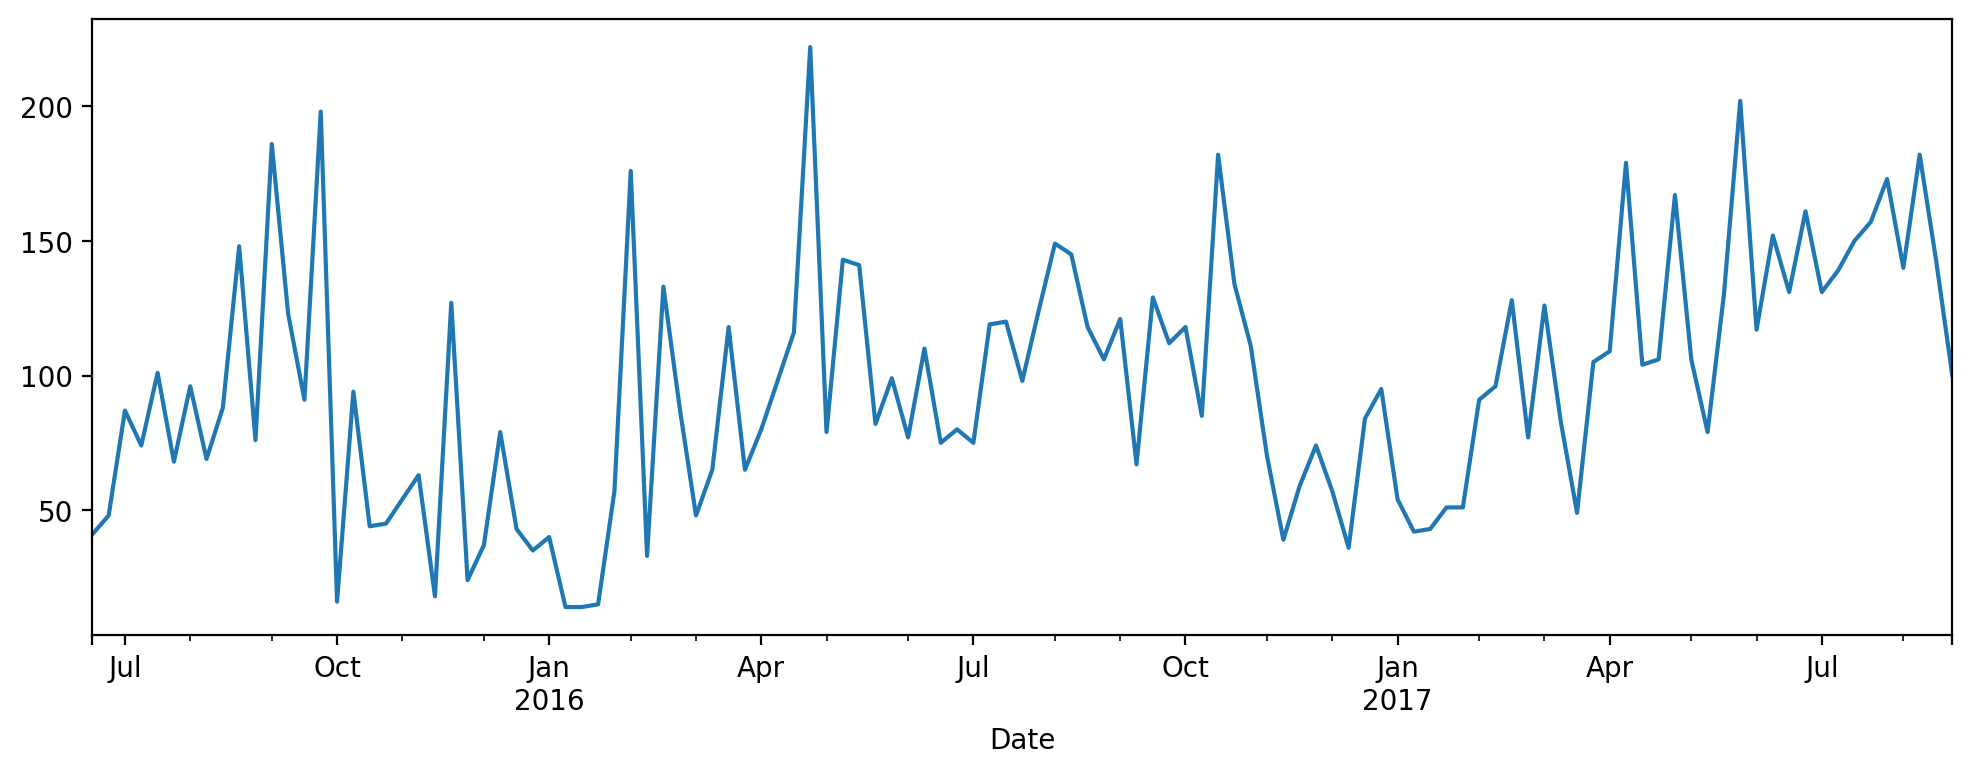

In [165]:
series = pd.Series(df['IsCanceled'])

plt.figure(figsize=(12, 4))
_ = series.plot()

In [166]:
arima_model = ARIMA(series, order=(1,0,0))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             IsCanceled   No. Observations:                  115
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -594.582
Date:                Mon, 24 Apr 2023   AIC                           1195.165
Time:                        12:27:57   BIC                           1203.400
Sample:                    06-21-2015   HQIC                          1198.507
                         - 08-27-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.6447      6.546     14.765      0.000      83.816     109.474
ar.L1          0.3622      0.087      4.156      0.000       0.191       0.533
sigma2      1812.6614    248.595      7.292      0.000    1325.423    2299.900
===================================================================================
Ljung-Box (L1) (Q):                   2.02   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.16   Prob(JB):                         0.26
Heteroskedasticity (H):               0.53   Skew:                             0.35
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

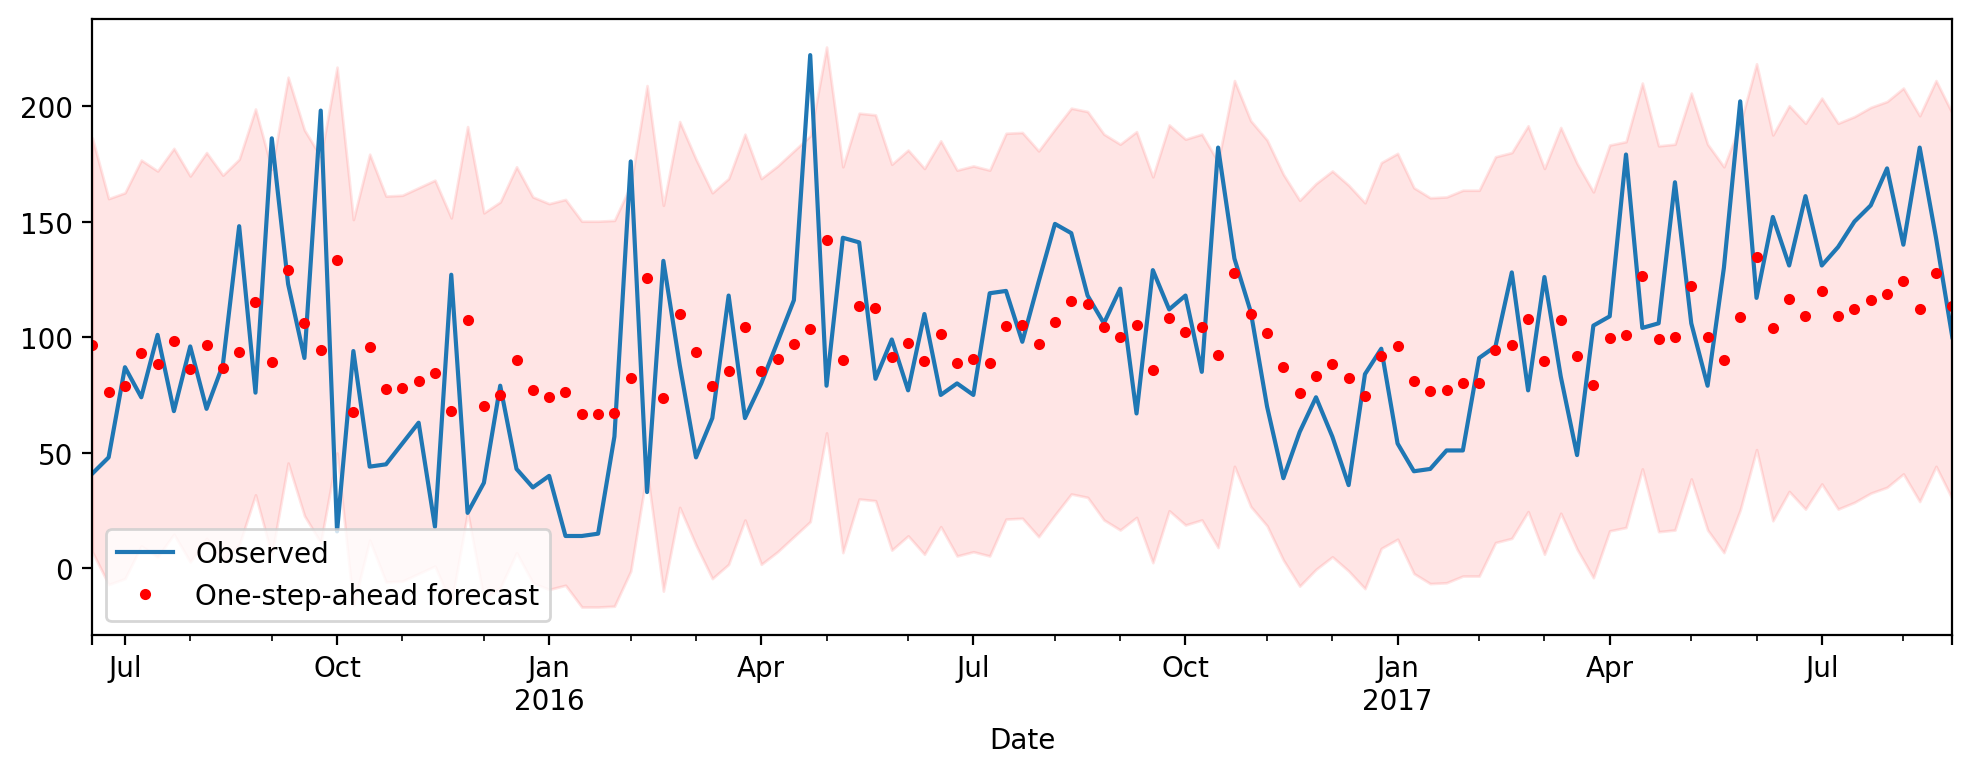

In [167]:
predict_mle = arima_model_fit.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci["lower IsCanceled"]
upper = predict_mle_ci["upper IsCanceled"]

# Graph
fig, ax = plt.subplots(figsize=(12, 4))

# Plot data points
series.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_mle_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho0, rho1, sigma]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bo

Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 23 seconds.


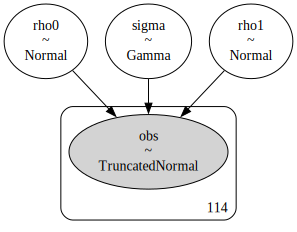

In [168]:
data = series.values

with pm.Model() as model:
    rho0 = pm.Normal("rho0", mu=0, sigma=1)
    rho1 = pm.Normal("rho1", mu=0, sigma=1)
    sigma = pm.Gamma("sigma", alpha=1, beta=1)
    mean = rho0 + rho1 * data[:-1]
    obs = pm.TruncatedNormal("obs", lower=0, mu=mean, sigma=sigma, observed=data[1:])
    idata = pm.sample(50_000, chains=4)

pm.model_to_graphviz(model)

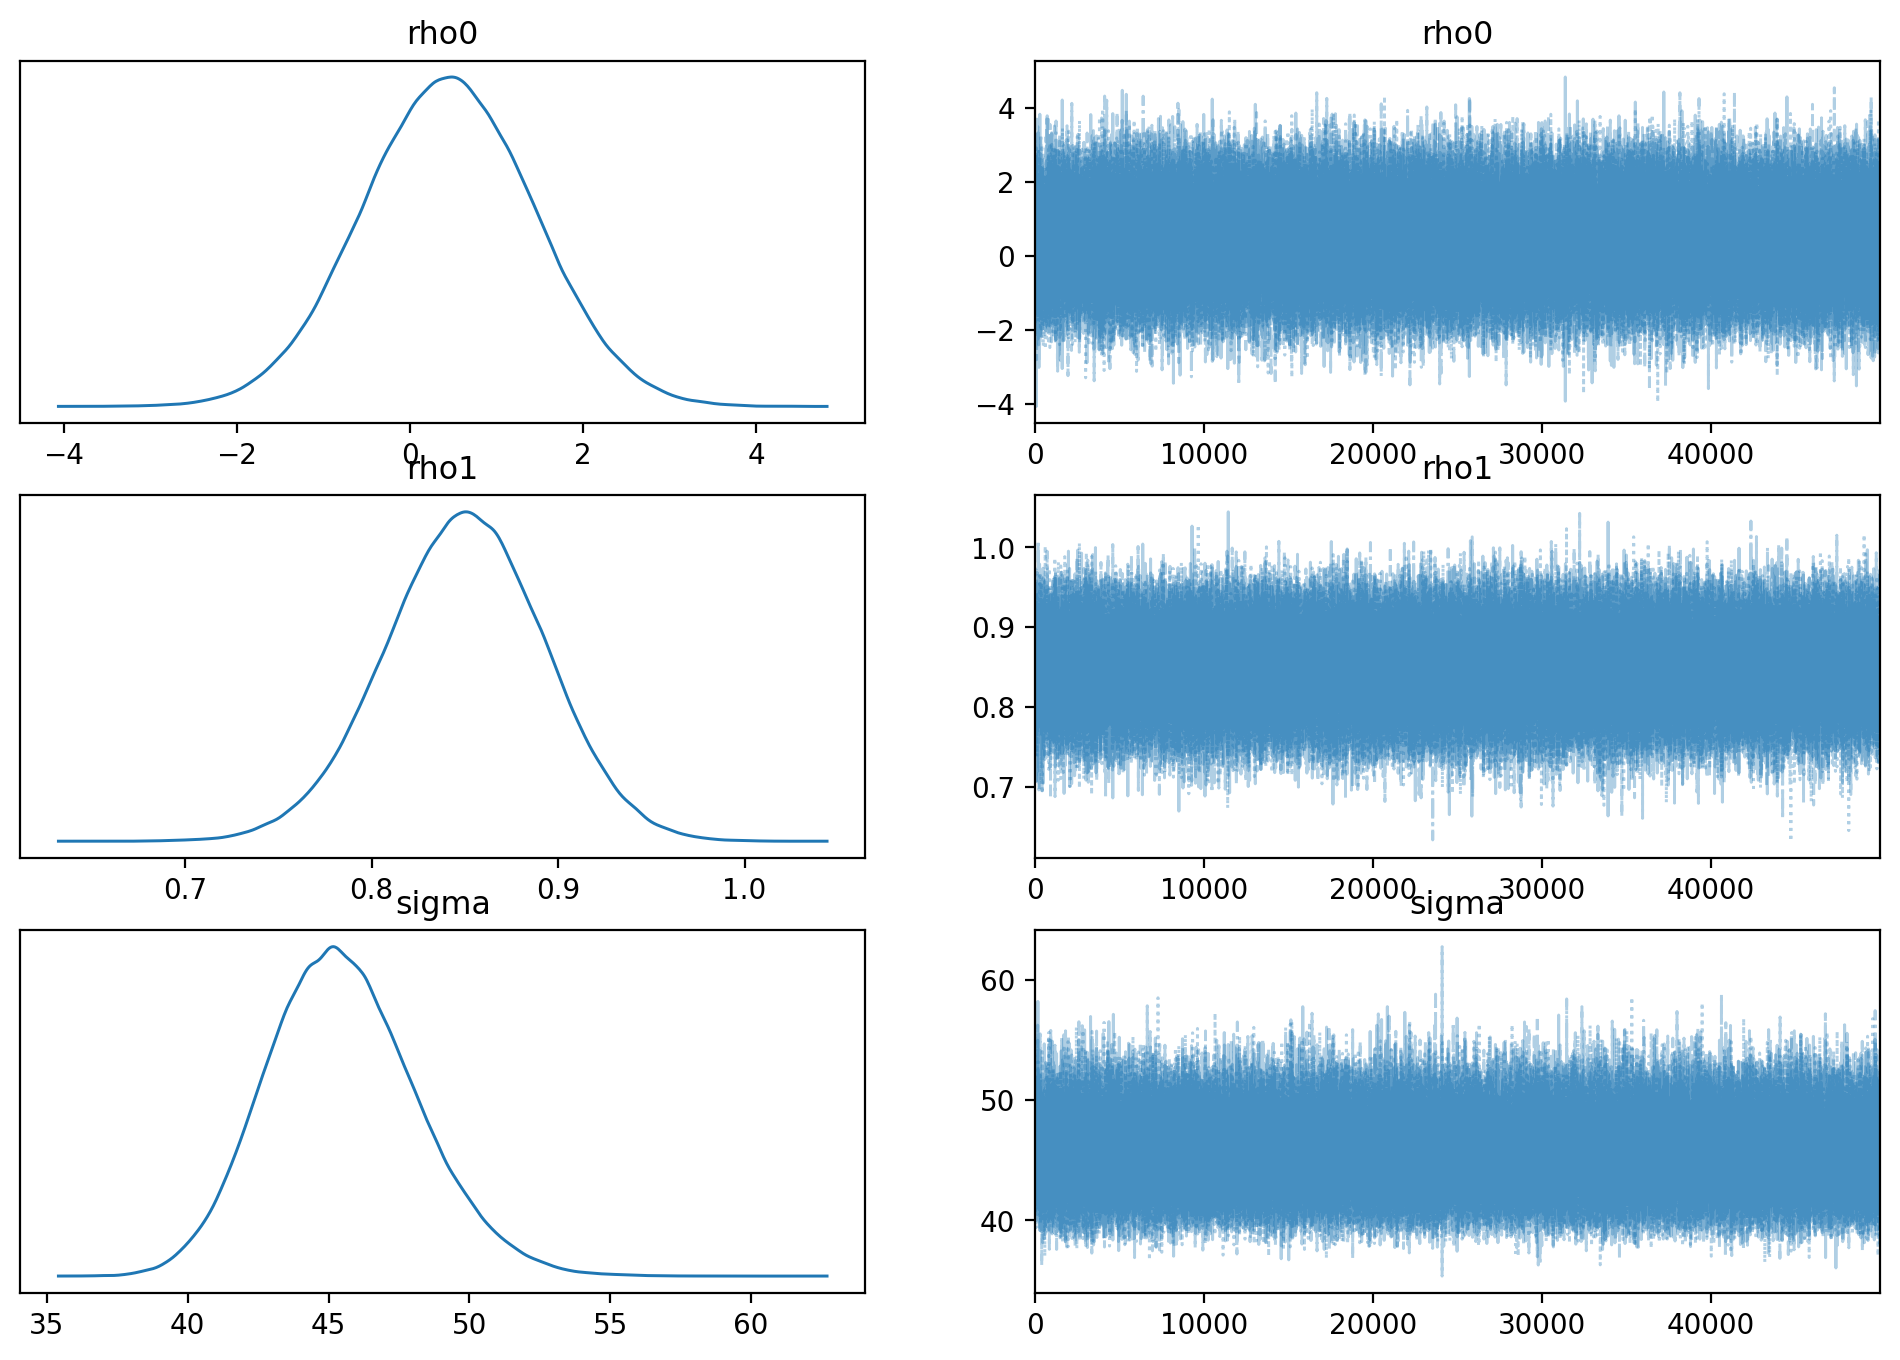

In [169]:
az.plot_trace(idata, combined=True, figsize=(12, 8));

In [170]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

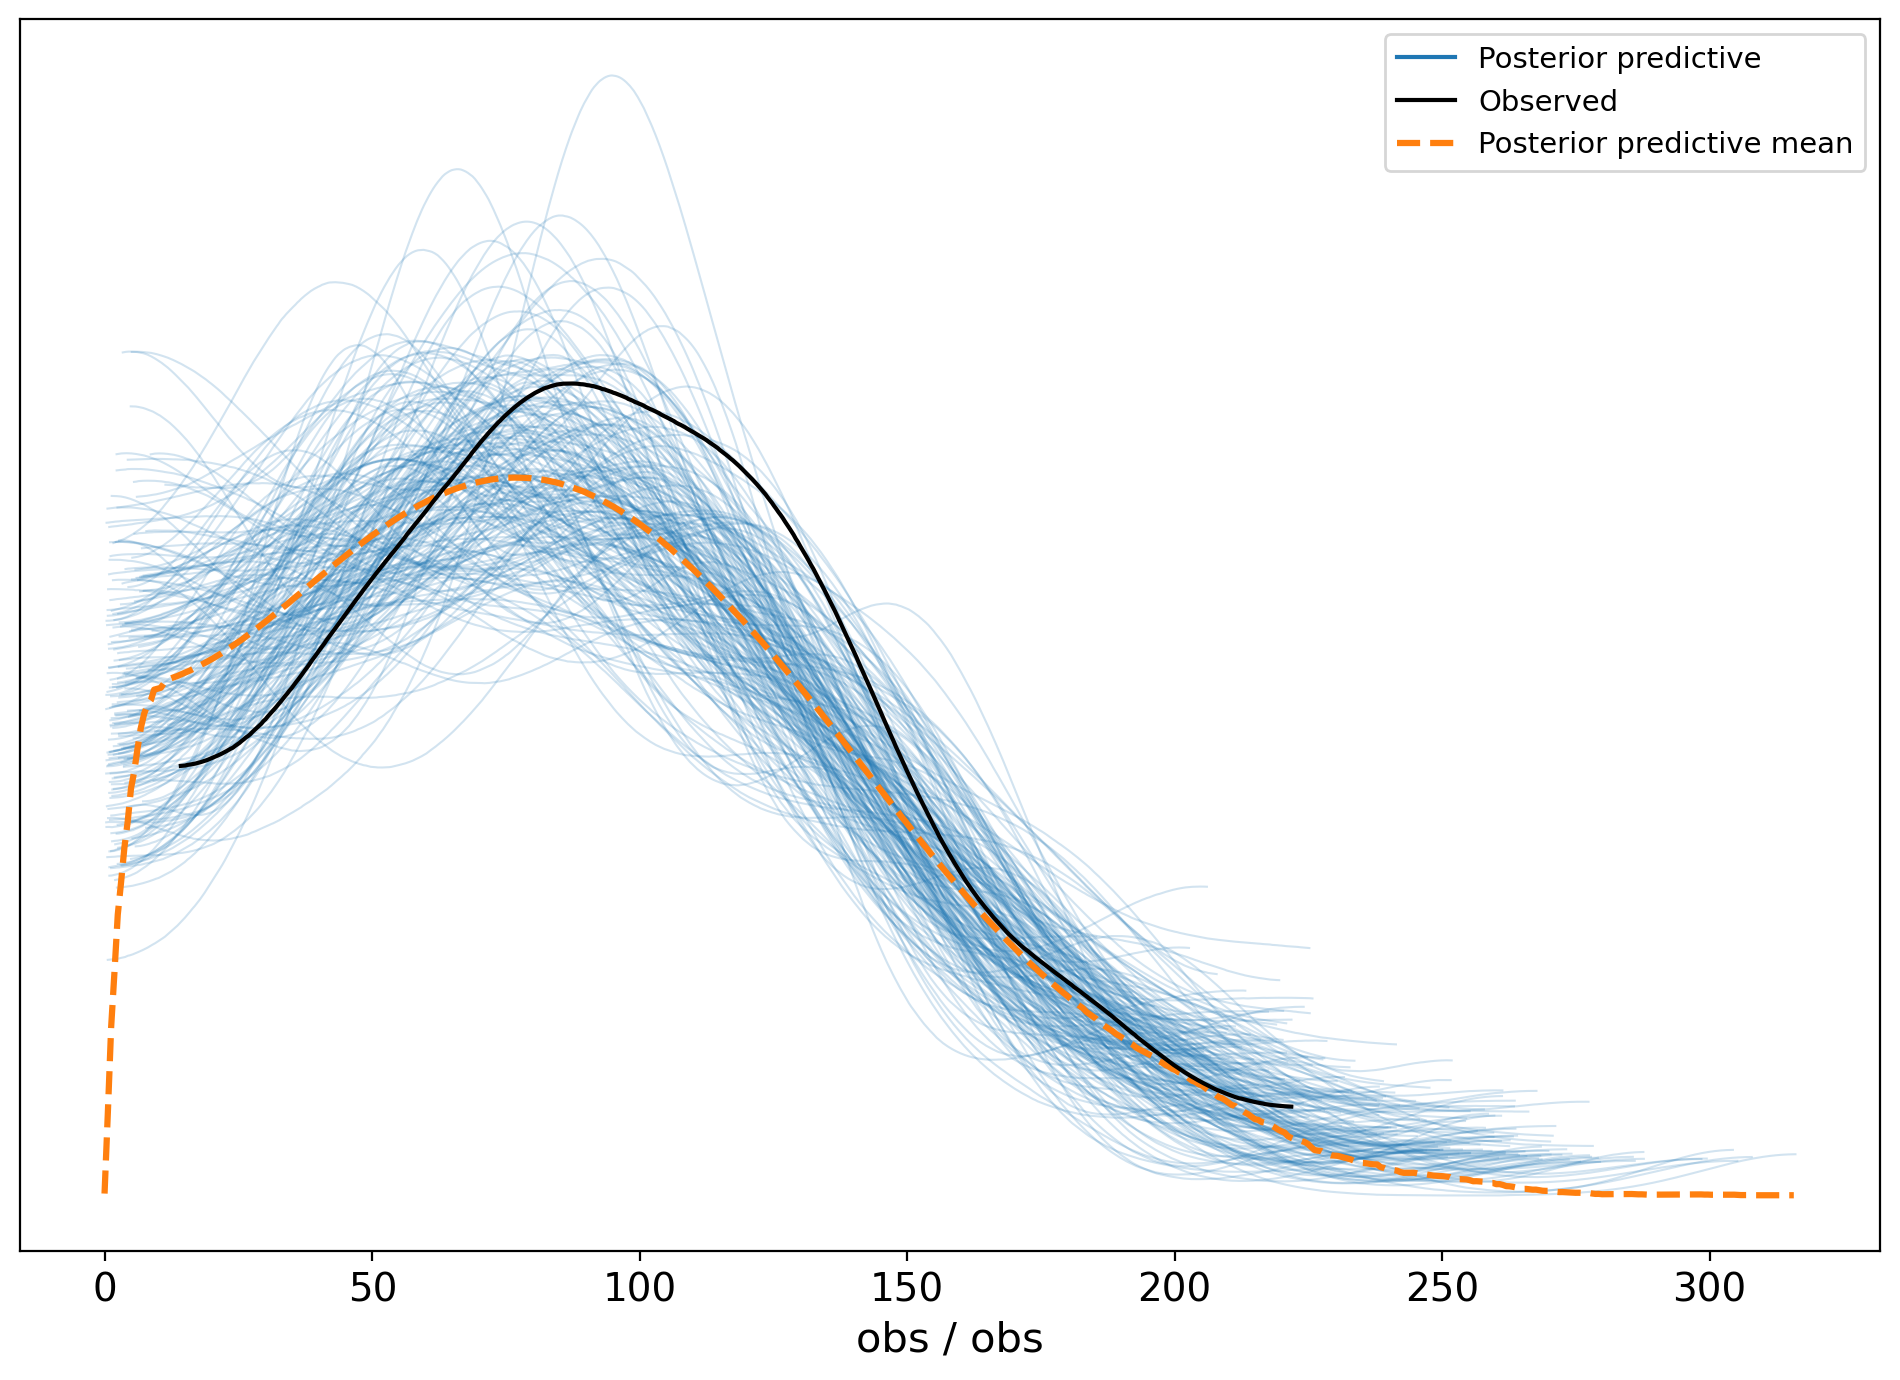

In [173]:
_ = az.plot_ppc(idata, num_pp_samples=200)

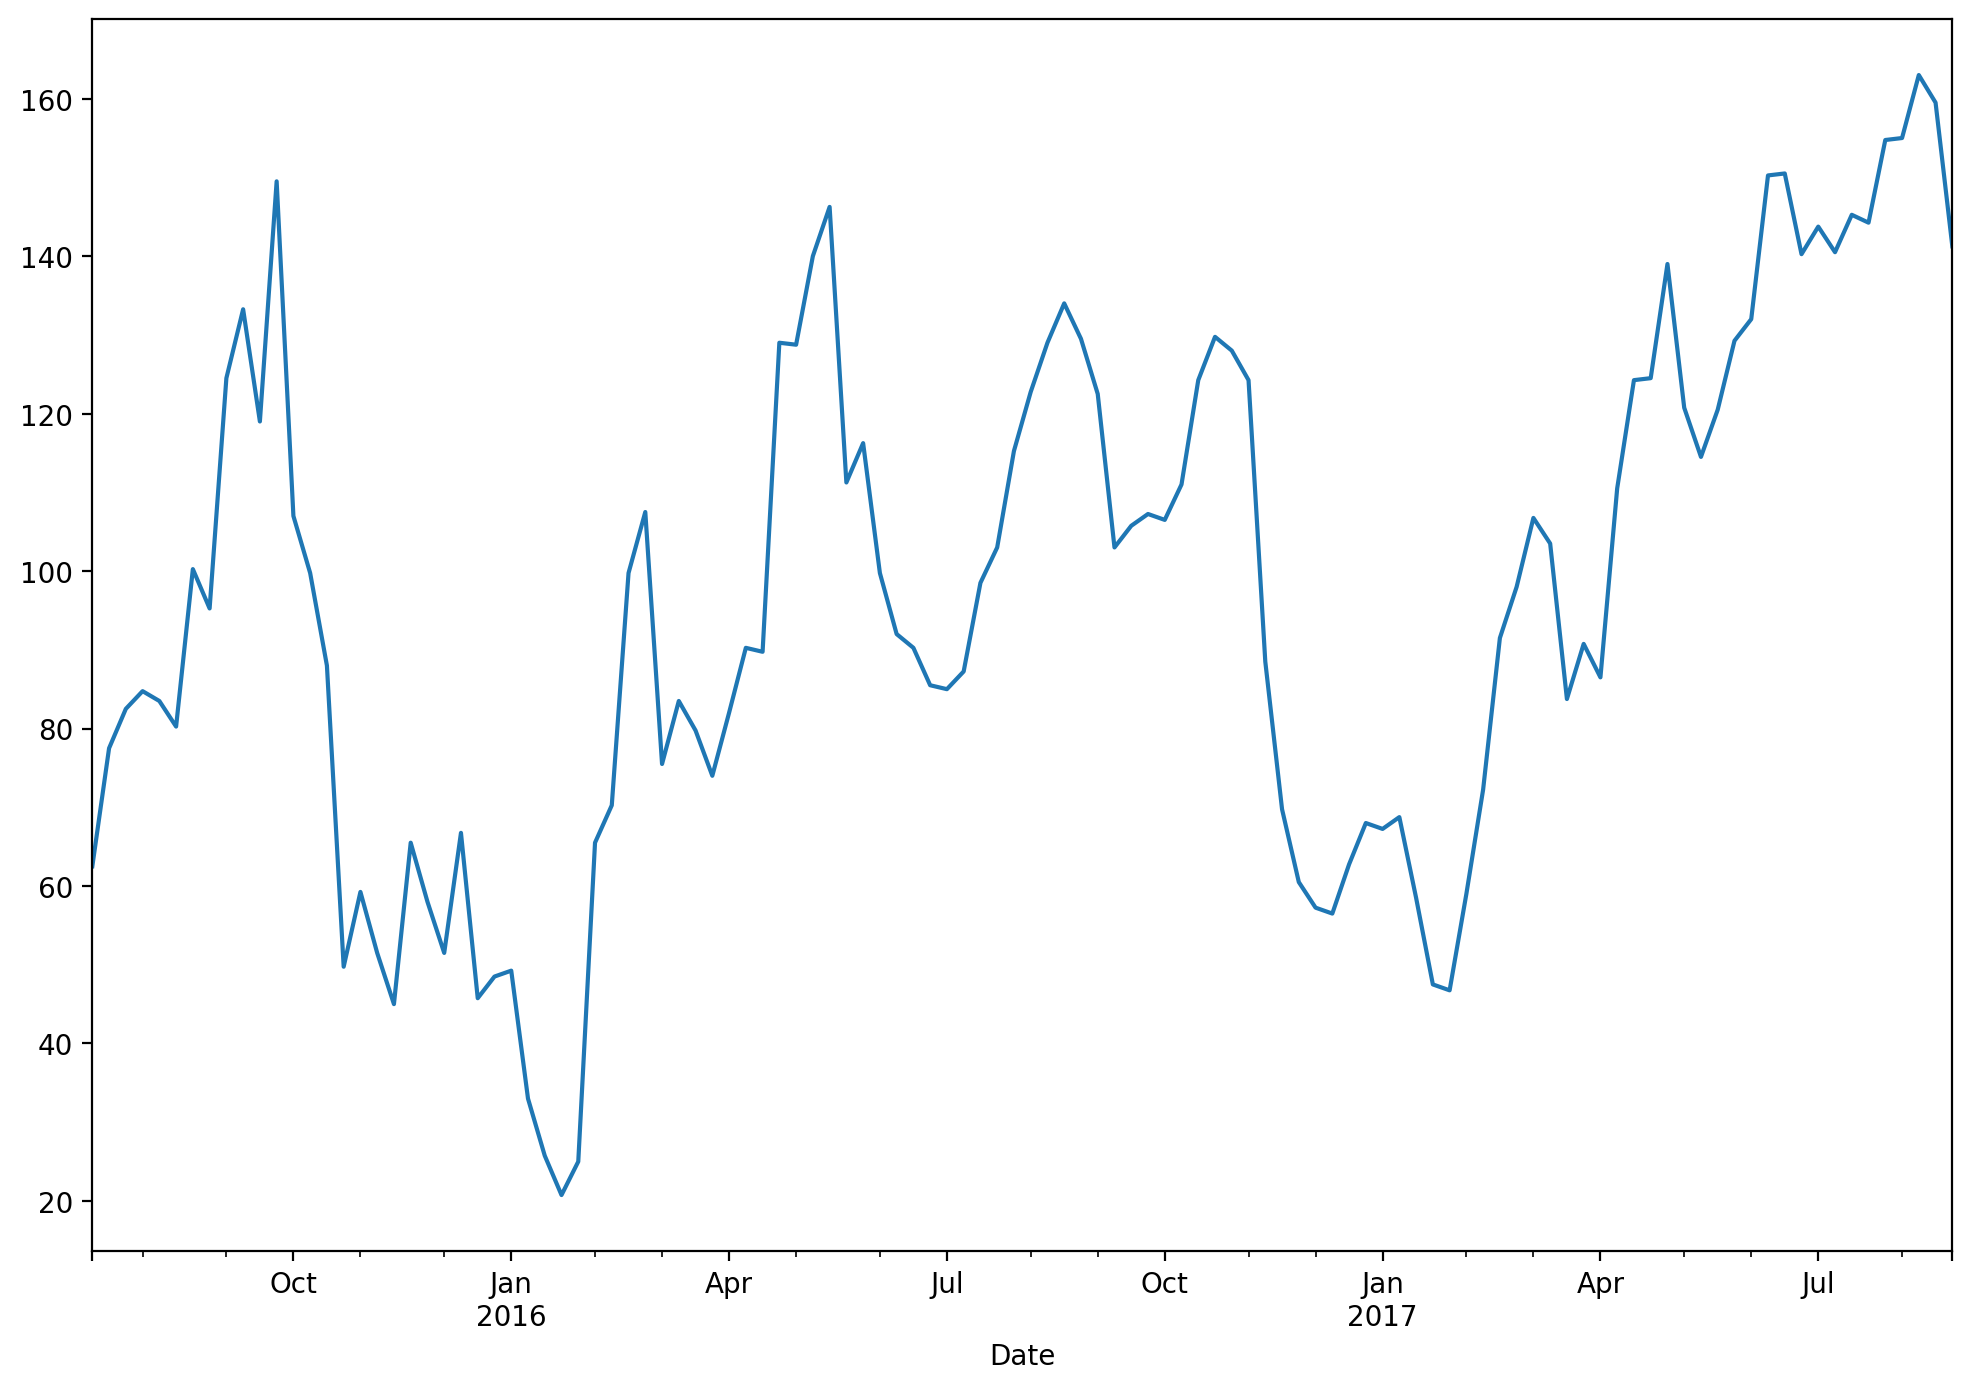

In [172]:
window_size = 4

windows = series.rolling(window_size)
series_smoothed = windows.mean().dropna()

_ = series_smoothed.plot()